# Project Two - NLP Disaster Tweets Classification 
#### Ilyas Saoud
#### ASU - DAT 402
#### Professor Marko Samara

**In this project, we will be using twitter to identify if a user is tweeting about a disaster or not. This could potentially help report emergencies with a certain accuracy. The data was taken once again from Kaggle: https://www.kaggle.com/competitions/nlp-getting-started. 
Warning: The text in our data contains offensive and profane language.**

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Exploratory Data Analysis

**0 = Tweet is about a disaster**

**1 = Tweet is not about a disaster**

In [3]:
print(train.target.value_counts())

0    4342
1    3271
Name: target, dtype: int64


## Pie Chart

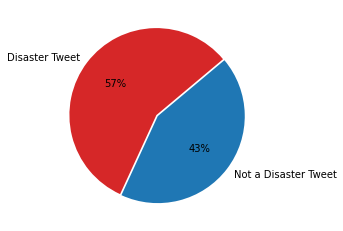

In [4]:
labels = ['Disaster Tweet','Not a Disaster Tweet']

plt.pie(train.target.value_counts(),explode = (0,0.02), labels = labels,autopct='%.0f%%',
        shadow=False,startangle=40,colors=('tab:red', 'tab:blue'))

rcParams['figure.figsize'] = 10.7,7.27

plt.show()

**Disaster Tweet dominates here, but not by much! Our data is fair enough to work with.**

In [5]:
train["text_len"] = train.text.str.len()

## Histogram of Text Length (Number of words in each tweet)

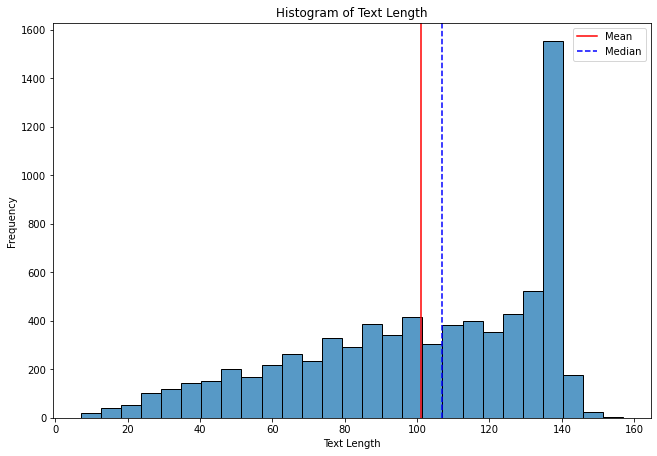

In [6]:
sns.histplot(data=train.text_len)
plt.axvline(x=train.text_len.mean(),
            color='red',label="Mean")
plt.axvline(x=train.text_len.median(),
            color='blue',linestyle='--',label="Median")
plt.xlabel("Text Length"), plt.ylabel("Frequency")
plt.title("Histogram of Text Length")
plt.legend()

In [7]:
print("Mean: ",train.text_len.mean())

Mean:  101.03743596479706


**A mean of 101 is a lot of words! We can expect to large amount of features moving forward.**

# Vectorization

## Let's look at the big picture

**This is an NLP project, and so we're going to be working with text data, but since computers can't understand words or language, we need a way to transform our text into numbers that make sense. So here is the big picture:**

* Text
> Text = "That big house is AWESOME! Plus, it has a red door"
* Standarize: We remove any punctuations, and lower() our text
> Standarized text = "that big house is awesome plus it has a red door"
* Create Tokens
> Tokens = "that", "big', "house", "is", "awesome", "plus", "it", "has", "a", "red","door"

**There are multiple methods we can use to tokenize our text, this will be discussed later.**
* Token indices
> Indices = 4,34,76,85,3,25,8,3,3,64,2

**Once we have our indices, there are multiple methods we can use to handle them, from encoding to embedding and more. We will discuss these methods later.** 

## Text Vectorization from scratch

**Code Source: Deep Learning with Python - Francois Chollet**

* **The standarize()** and **tokenize()** functions were explaiend above.

* **make_vocabulary()** creates indices and stores the vocabulary of the text

* **encode()** will return a vectorized array

* **decode()** will return a text given a vectorized array, using the vocabulary dictionary{}

In [8]:
#Code Source: Deep Learning with Python - Francois Chollet

class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text
                       if char not in string.punctuation)
        return 
    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()
    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
                    self.inverse_vocabulary = dict(
                        (v, k) for k, v in self.vocabulary.items())
    def encode(self, text):
                        text = self.standardize(text)
                        tokens = self.tokenize(text)
                        return [self.vocabulary.get(token, 1) for token in tokens]
    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

* **Here we created a dataset, then called out our Vectorizer() to make_vocabulary() out of our dataset**

In [9]:
dataset = ['I am SICk of this. come on just win the game tomorrow',
          'Yesterday I lost the bet...',
          'Watching the game is fun, but playing it is better.']

In [10]:
vectorizer = Vectorizer()
vectorizer.make_vocabulary(dataset)

* **Here we encoded and decoded a new sentence, "we" and "we'll" was not recognized, so it returned a value of 1 when encoded, and '[UNK]' when decoded**

In [11]:
sentence = "Yesterday we lost the game, but we'll win tomorrow"
encoded = vectorizer.encode(sentence)
decoded = vectorizer.decode(encoded)
encoded,decoded

([14, 1, 15, 11, 12, 20, 1, 10, 13],
 'yesterday [UNK] lost the game but [UNK] win tomorrow')

*** Here we are using TensorFlow library:**
> tensorflow.keras.layers.experimental.preprocessing import TextVectorization

*** .adapt() is similar to our .make_vocabulary()**

In [12]:
text_vectorization = TextVectorization(
    output_mode ='int')
text_vectorization.adapt(dataset)
encoded = text_vectorization(sentence)
encoded

2022-12-01 17:57:28.657191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 17:57:28.742805: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 17:57:28.743648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 17:57:28.745222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<tf.Tensor: shape=(9,), dtype=int64, numpy=array([ 6,  1, 15,  2,  5, 20,  1,  7,  9])>

In [13]:
X = train['text'].values
y = train['target'].values
X

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

### Custom Standarization
*** Removes html, lowers text, removes punctuations**

In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

### Train Test Split

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size = 0.25,
                                                random_state=0,
                                                stratify=y)

### Text Vectorization Using 'int' as output mode

In [16]:
text_vectorization_int = TextVectorization(standardize=custom_standardization,
                                       output_mode = 'int')


In [17]:
text_vectorization_int.adapt(X)

In [18]:
X_train_int = text_vectorization_int(X_train)
X_test_int = text_vectorization_int(X_test)


X_train_int.shape,X_test_int.shape

(TensorShape([5709, 31]), TensorShape([1904, 29]))

In [19]:
X_test_int = np.hstack((X_test_int, np.zeros([1904,2])))
X_test_int.shape

(1904, 31)

# Naive Bayes Classifer!
**Let's start a basic algorithm, the Naive Bayes Classifier.** 

**The Propability of y=1 given all of our features:**
> P(x|y) = {1 if P(x|y)>0.5}

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(X_train_int, y_train)

pred = gnb.predict(X_test_int)


print("Accuracy score for Random Forest:",round(accuracy_score(y_test, pred),5))

Accuracy score for Random Forest: 0.43015


**Not the best results here, Let's try building a Neural Network Model.**

# Building our Neural Network Model

In [21]:
np.random.seed(122) #set the seed in numpy
tf.random.set_seed(1233)  #set the seed in tensorflow

#building the architecture of the model


mynet = tf.keras.Sequential([
    tf.keras.Input(shape=(31,)),
    layers.Dense(units=16, activation='relu', name='hidden1'),
    layers.Dense(units=1, activation='sigmoid', name='output_layer')
], name='mynet') #name is used in printout (can be different from 'mynet')

#compiling the model
mynet.compile(optimizer='rmsprop', #root mean square propagation optimizer
              loss='binary_crossentropy', #measures model performance/accuracy
              metrics=['accuracy']
             ) 

mynet.summary()

Model: "mynet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                512       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________


# Fitting our Training data

In [22]:
history = mynet.fit(X_train_int, y_train, validation_data = (X_test_int,y_test), epochs = 20)

Epoch 1/20
179/179 [==============================] - 2s 3ms/step - loss: 781.0867 - accuracy: 0.5201 - val_loss: 386.5309 - val_accuracy: 0.5273
Epoch 2/20
179/179 [==============================] - 1s 3ms/step - loss: 307.0296 - accuracy: 0.5185 - val_loss: 265.6634 - val_accuracy: 0.5084
Epoch 3/20
179/179 [==============================] - 0s 3ms/step - loss: 213.5302 - accuracy: 0.5302 - val_loss: 199.7580 - val_accuracy: 0.5294
Epoch 4/20
179/179 [==============================] - 0s 3ms/step - loss: 156.6914 - accuracy: 0.5351 - val_loss: 149.8792 - val_accuracy: 0.5336
Epoch 5/20
179/179 [==============================] - 1s 4ms/step - loss: 119.1499 - accuracy: 0.5490 - val_loss: 112.3637 - val_accuracy: 0.5404
Epoch 6/20
179/179 [==============================] - 1s 3ms/step - loss: 94.3887 - accuracy: 0.5427 - val_loss: 92.1646 - val_accuracy: 0.5299
Epoch 7/20
179/179 [==============================] - 0s 3ms/step - loss: 76.7539 - accuracy: 0.5458 - val_loss: 79.8858 - val

In [23]:
test_loss, test_acc = mynet.evaluate(X_test_int, y_test, verbose=2)

60/60 - 0s - loss: 28.2854 - accuracy: 0.5446


# Results

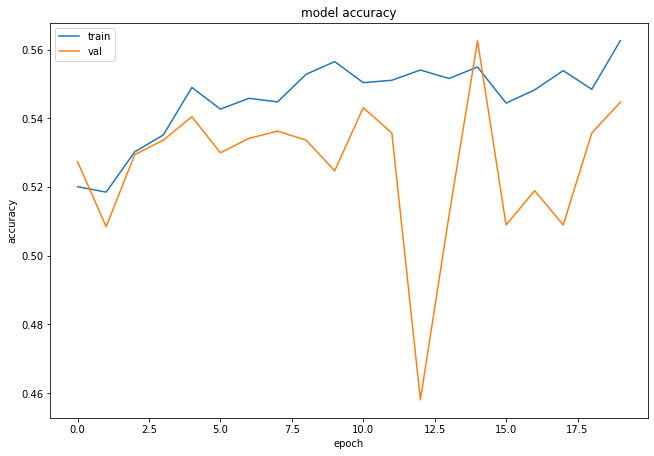

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### As we can see, both our methods preformed horribly. Let's see what we can do to make them better!

### Text Vectorization Using different methods.

* First, Let's change our output_mode to "count", this will output an int array containing a count of that number appearing in that batch, and 0 everywhere else.
> output_mode = 'count'
* Next, Let's set a limit for our tokens or else we'd be indexing every word or ngrams of words in our vocabulary. Tokens can be thought of as features (vocabulary), with our output_mode being 'count', the number of features will be very large, so we will limit them to the top 20,000, to ignore the words that only occur once or twice. 
> max_tokens = 20000
* Finally, let's set our ngrams to 5. 
> ngrams = 5

**For a quick ngrams explanation:**

* Text:
> "hello pretty cat"

* with ngrams = 1, our text will tokenize to:
> "hello","pretty","cat".

* But with ngrams = 2, our text will tokenize to:
> "hello","hello pretty","pretty","pretty cat", "cat", etc...


In [25]:
text_vectorization_count = TextVectorization(standardize=custom_standardization,
                                       max_tokens = 20000,
                                       output_mode = 'count',
                                       ngrams=5)


In [26]:
text_vectorization_count.adapt(X)

In [27]:
X_train_count = text_vectorization_count(X_train)
X_test_count = text_vectorization_count(X_test)


X_train_count.shape,X_test_count.shape

(TensorShape([5709, 20000]), TensorShape([1904, 20000]))

# Back to Naive Bayes one last time

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(X_train_count, y_train)

pred = gnb.predict(X_test_count)


print("Accuracy score for Random Forest:",round(accuracy_score(y_test, pred),5))

Accuracy score for Random Forest: 0.75315


**Much Better! Let's try our Neural Network model again, with some changes.**

# Building our new model
### Here we added a Dropout Layer for Regularization 

In [29]:
np.random.seed(122) #set the seed in numpy
tf.random.set_seed(1233)  #set the seed in tensorflow

#building the architecture of the model


mynet = tf.keras.Sequential([
    tf.keras.Input(shape=(20000,)),
    layers.Dense(units=16, activation='relu', name='hidden1'),
    layers.Dropout(0.7),
    layers.Dense(units=1, activation='sigmoid', name='output_layer')
], name='mynet') #name is used in printout (can be different from 'mynet')

#compiling the model
mynet.compile(optimizer='rmsprop', #root mean square propagation optimizer
              loss='binary_crossentropy', #measures model performance/accuracy
              metrics=['accuracy']
             ) 

mynet.summary()

Model: "mynet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                320016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = mynet.fit(X_train_count, y_train, validation_data = (X_test_count,y_test), epochs = 20, batch_size=20)

Epoch 1/20
286/286 [==============================] - 2s 4ms/step - loss: 0.6597 - accuracy: 0.6211 - val_loss: 0.6025 - val_accuracy: 0.7584
Epoch 2/20
286/286 [==============================] - 1s 3ms/step - loss: 0.5789 - accuracy: 0.7154 - val_loss: 0.5285 - val_accuracy: 0.7789
Epoch 3/20
286/286 [==============================] - 1s 3ms/step - loss: 0.5339 - accuracy: 0.7528 - val_loss: 0.5072 - val_accuracy: 0.7852
Epoch 4/20
286/286 [==============================] - 1s 4ms/step - loss: 0.5019 - accuracy: 0.7716 - val_loss: 0.5061 - val_accuracy: 0.7878
Epoch 5/20
286/286 [==============================] - 1s 4ms/step - loss: 0.4797 - accuracy: 0.7831 - val_loss: 0.5172 - val_accuracy: 0.7731
Epoch 6/20
286/286 [==============================] - 1s 4ms/step - loss: 0.4726 - accuracy: 0.7881 - val_loss: 0.5071 - val_accuracy: 0.7936
Epoch 7/20
286/286 [==============================] - 1s 4ms/step - loss: 0.4613 - accuracy: 0.7994 - val_loss: 0.5016 - val_accuracy: 0.8062
Epoch 

In [31]:
test_loss, test_acc = mynet.evaluate(X_test_count, y_test, verbose=2)

60/60 - 0s - loss: 0.5497 - accuracy: 0.8235


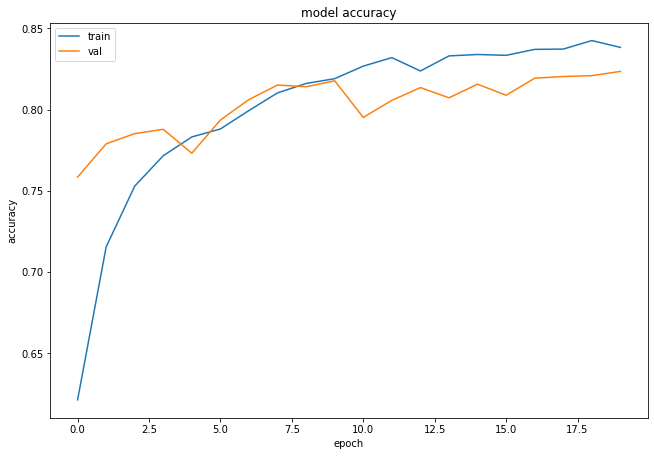

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Much Better!
### What else can be done?

Next, I would love to learn more about transformers, and word Embeddings. Transformers are very popular in NLP, and could potentially increase our accuracy! NLP and Computer Vision are two fields in the deep learning world that I am very interested in. But first, I must master the foundation of all the basic algorithms. Thank you!
